In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [ ]:
## Loading in the data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Size of batch
batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
## Training and Test data



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


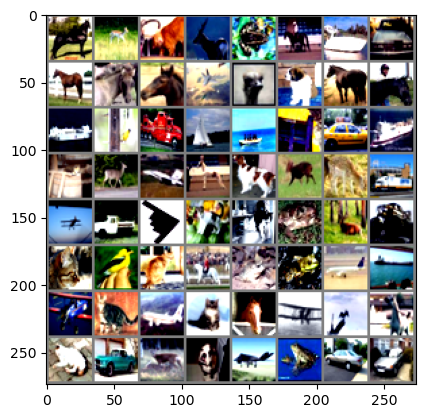

horse deer  cat   deer  frog  horse ship  car   horse horse horse plane bird  dog   horse horse ship  bird  truck ship  ship  truck car   ship  cat   deer  plane horse dog   deer  deer  truck plane truck plane cat   cat   frog  deer  truck cat   bird  cat   horse frog  frog  plane ship  plane cat   plane cat   horse plane bird  horse cat   car   deer  dog   plane frog  car   car  


In [77]:
# Show a simple image 
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    nping = img.numpy()
    plt.imshow(np.transpose(nping, (1, 2, 0)))
    plt.show()

# Get ssome of the images
data = iter(trainloader)
images, labels = next(data)

# Show images
imshow(torchvision.utils.make_grid(images))

# print put the labels of the images
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
    

In [78]:
# Donwsampling av datasettet for å få modellen til å lære kategorien bedre

In [79]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First Convolutional Layer (Input: 3 channels, Output: 6, Kernel: 5x5)
        self.conv_layer1 = nn.Conv2d(3, 6, 5)  
        # Second Convolutional Layer (Input: 6 channels, Output: 16, Kernel: 5x5)
        self.conv_layer2 = nn.Conv2d(6, 16, 5)  
        
        # Dropout layers
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 5 * 5, 128)  # Adjusted input size
        self.fc2 = nn.Linear(128, 10)  # Output layer (10 classes)

    def forward(self, data):
        # Convolutional Layer 1 + ReLU + Pooling
        data = F.relu(self.conv_layer1(data))
        data = F.max_pool2d(data, 2)  

        # Convolutional Layer 2 + ReLU + Pooling
        data = F.relu(self.conv_layer2(data))
        data = F.max_pool2d(data, 2)  

        # Apply dropout
        data = self.dropout1(data)

        # Flatten tensor for fully connected layers
        data = torch.flatten(data, 1)

        # Fully Connected Layer 1 + ReLU + Dropout
        data = F.relu(self.fc1(data))
        data = self.dropout2(data)

        # Output Layer
        data = self.fc2(data)

        return F.log_softmax(data, dim=1)

# Instantiate the model
neural_network = Net()

# Function to initialize weights
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

neural_network.apply(init_weights)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
neural_network.to(device)  # Move model to GPU

print(neural_network)


Net(
  (conv_layer1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv_layer2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
## Defining a loss function

# Loss function used to measure how well the models prediction match the actual labels
criterion = nn.CrossEntropyLoss()
# Updates the models loss during traning with SDG optimizer
optimizer = optim.Adam(neural_network.parameters(), lr=0.01, momentum=0.9)

In [81]:
## Traning a Network 

for epoch in range(10): # Loop over ther dataset multiple times (epochs)
    
    # Total loss over all batches
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # Train on GPU for faster traning
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Extracting inputs and labels from the batch
        inputs, labels = data 
        
        # get the inputs and labels
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients for each batch
        optimizer.zero_grad()
        
        outputs = neural_network(inputs)
        
        # Predict the loss of the model
        loss = criterion(outputs, labels)
        
        # Back propagation (Gradient Computation)
        loss.backward()
        
        # Preformes gradient decent on the new weights
        optimizer.step()
        
        # Statistics 
        running_loss += loss.item()
        if i % 100 == 99:
            print(f'Epoch [{epoch+1}/10], Step [{i+1}/{len(trainloader)}], Loss: {running_loss / 100:.4f}')
            running_loss = 0.0 # Reset the loss

print("Finished training")

Epoch [1/10], Step [100/782], Loss: 2.3566
Epoch [1/10], Step [200/782], Loss: 2.1732
Epoch [1/10], Step [300/782], Loss: 2.0737
Epoch [1/10], Step [400/782], Loss: 2.0355
Epoch [1/10], Step [500/782], Loss: 1.9698
Epoch [1/10], Step [600/782], Loss: 1.9245
Epoch [1/10], Step [700/782], Loss: 1.9297
Epoch [2/10], Step [100/782], Loss: 1.8655
Epoch [2/10], Step [200/782], Loss: 1.8681
Epoch [2/10], Step [300/782], Loss: 1.8396
Epoch [2/10], Step [400/782], Loss: 1.8336
Epoch [2/10], Step [500/782], Loss: 1.8241
Epoch [2/10], Step [600/782], Loss: 1.8072
Epoch [2/10], Step [700/782], Loss: 1.8038
Epoch [3/10], Step [100/782], Loss: 1.7637
Epoch [3/10], Step [200/782], Loss: 1.7629
Epoch [3/10], Step [300/782], Loss: 1.7862
Epoch [3/10], Step [400/782], Loss: 1.7537
Epoch [3/10], Step [500/782], Loss: 1.7475
Epoch [3/10], Step [600/782], Loss: 1.7664
Epoch [3/10], Step [700/782], Loss: 1.7490
Epoch [4/10], Step [100/782], Loss: 1.7499
Epoch [4/10], Step [200/782], Loss: 1.7294
Epoch [4/10